In [19]:
import pandas as pd
import re 
import spacy
import nltk as nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import time
import math
import string
import gensim
import pyLDAvis
import gensim
import os
import requests
import pprint
import seaborn as sns 
import matplotlib.pyplot as plt
#import pyLDAvis.gensim
#import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import clear_output
from wordcloud import WordCloud
from collections import Counter
from joblib import dump, load
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel


pyLDAvis.enable_notebook()
#nlp = spacy.load("en_core_web_sm")

In [4]:
import pandarallel
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
%%time

df = pd.read_parquet('df_vader.parquet', engine='pyarrow')
df.shape

CPU times: user 15.5 s, sys: 3 s, total: 18.5 s
Wall time: 15 s


(170984, 12)

In [6]:
df.sample(3, random_state = 42)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,initial_sent,sentiment_score,sentiment
84444,2021-03-30,2021,3,30,1,Cambridge Quantum Computing Pioneers Quantum M...,Cambridge Quantum Computing Pioneers Quantum M...,"[cambridge, quantum, computing, pioneers, quan...","[cambridge, quantum, computing, pioneers, quan...",1,0.9323,Positive
35622,2022-12-08,2022,12,8,3,Aetina Launches New ASICBased Edge AI System P...,Aetina Launches New ASICBased Edge AI System P...,"[aetina, launches, new, asicbased, edge, ai, s...","[aetina, launches, new, asicbased, edge, ai, s...",1,0.9944,Positive
140578,2020-12-04,2020,12,4,4,Emotion AI Software Market To Observe Exponent...,Emotion AI Software Market To Observe Exponent...,"[emotion, ai, software, market, observe, expon...","[emotion, ai, software, market, observe, expon...",0,0.9979,Positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170984 entries, 0 to 200331
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                170984 non-null  datetime64[ns]
 1   year                170984 non-null  int32         
 2   month               170984 non-null  int32         
 3   day                 170984 non-null  int32         
 4   dayofweek           170984 non-null  int32         
 5   clean_title         170984 non-null  object        
 6   clean_text          170984 non-null  object        
 7   clean_title_tokens  170984 non-null  object        
 8   clean_text_tokens   170984 non-null  object        
 9   initial_sent        170984 non-null  int64         
 10  sentiment_score     170984 non-null  float64       
 11  sentiment           170984 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(5)
memory usage: 14.3+ MB

### Topic Modelling on Sentiments

In [8]:
df_pos = df[df["sentiment"]=="Positive"]
df_neg = df[df["sentiment"]=="Negative"]

In [9]:
df_pos.head(2)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,initial_sent,sentiment_score,sentiment
0,2021-03-18,2021,3,18,3,Artificial intelligence improves parking effic...,Artificial intelligence improves parking effic...,"[artificial, intelligence, improves, parking, ...","[artificial, intelligence, improves, parking, ...",0,0.9977,Positive
1,2020-02-27,2020,2,27,3,Children With Autism Saw Their Learning and So...,Children With Autism Saw Their Learning and So...,"[children, autism, saw, learning, social, skil...","[children, autism, saw, learning, social, skil...",0,0.9989,Positive


In [10]:
df_neg.head(2)

,date,year,month,day,dayofweek,clean_title,clean_text,clean_title_tokens,clean_text_tokens,initial_sent,sentiment_score,sentiment
14,2023-04-06,2023,4,6,3,Video Trump deepfakes on social media prompt w...,Video Trump deepfakes on social media prompt w...,"[video, trump, deepfakes, social, medium, prom...","[video, trump, deepfakes, social, medium, prom...",0,-0.9775,Negative
71,2020-12-08,2020,12,8,1,Abu Dhabi to install AI road system that detec...,Abu Dhabi to install AI road system that detec...,"[abu, dhabi, install, ai, road, system, detect...","[abu, dhabi, install, ai, road, system, detect...",0,-0.9571,Negative


**Postive sentiment topic modelling**

In [11]:
dictionary_text_pos = corpora.Dictionary(df_pos["clean_text_tokens"])
dictionary_text_neg = corpora.Dictionary(df_neg["clean_text_tokens"])

In [12]:
doc_term_matrix_text_pos = [dictionary_text_pos.doc2bow(doc) for doc in df_pos["clean_text_tokens"]]
doc_term_matrix_text_neg = [dictionary_text_neg.doc2bow(doc) for doc in df_neg["clean_text_tokens"]]

In [13]:
Lda = gensim.models.ldamodel.LdaModel

In [21]:
import multiprocessing
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors

print(f'Using {workers} workers')

Using 64 workers


In [22]:
%%time 
lda_model_pos = LdaMulticore(corpus=doc_term_matrix_text_pos,
                   id2word=dictionary_text_pos,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

print(*lda_model_pos.print_topics(num_topics=10, num_words=10), sep='\n')

(0, '0.014*"ai" + 0.009*"machine" + 0.008*"learning" + 0.008*"market" + 0.007*"stock" + 0.006*"company" + 0.006*"news" + 0.006*"nasdaq" + 0.005*"price" + 0.005*"data"')
(1, '0.012*"ai" + 0.005*"ha" + 0.005*"new" + 0.005*"data" + 0.005*"chatgpt" + 0.005*"company" + 0.004*"said" + 0.004*"wa" + 0.004*"technology" + 0.004*"news"')
(2, '0.023*"ai" + 0.006*"gray" + 0.006*"data" + 0.006*"technology" + 0.006*"group" + 0.006*"company" + 0.005*"customer" + 0.005*"media" + 0.005*"platform" + 0.005*"solution"')
(3, '0.012*"ai" + 0.006*"news" + 0.005*"new" + 0.005*"intelligence" + 0.005*"data" + 0.005*"artificial" + 0.004*"ha" + 0.004*"technology" + 0.004*"said" + 0.003*"use"')
(4, '0.011*"new" + 0.009*"ai" + 0.005*"republic" + 0.005*"ha" + 0.004*"open" + 0.004*"technology" + 0.003*"company" + 0.003*"data" + 0.003*"wa" + 0.003*"news"')
(5, '0.010*"ai" + 0.006*"health" + 0.006*"patient" + 0.005*"data" + 0.005*"new" + 0.004*"technology" + 0.004*"ha" + 0.003*"intelligence" + 0.003*"research" + 0.003*"

**Negative sentiment topic modelling**

In [23]:
lda_model_neg = LdaMulticore(corpus=doc_term_matrix_text_neg,
                   id2word=dictionary_text_neg,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

print(*lda_model_neg.print_topics(num_topics=10, num_words=10), sep='\n')

(0, '0.008*"news" + 0.007*"ai" + 0.006*"new" + 0.005*"ha" + 0.004*"chatgpt" + 0.004*"wa" + 0.004*"said" + 0.003*"data" + 0.003*"us" + 0.003*"use"')
(1, '0.009*"ai" + 0.009*"image" + 0.009*"ago" + 0.009*"news" + 0.007*"hour" + 0.006*"new" + 0.005*"said" + 0.005*"ha" + 0.005*"wa" + 0.004*"musk"')
(2, '0.011*"cancer" + 0.010*"ai" + 0.006*"lunit" + 0.005*"study" + 0.004*"wa" + 0.004*"patient" + 0.003*"gray" + 0.003*"group" + 0.003*"scope" + 0.003*"ha"')
(3, '0.010*"ai" + 0.006*"wa" + 0.006*"news" + 0.006*"ha" + 0.005*"said" + 0.004*"company" + 0.004*"new" + 0.003*"us" + 0.003*"people" + 0.003*"use"')
(4, '0.023*"ago" + 0.014*"hour" + 0.007*"news" + 0.007*"new" + 0.006*"day" + 0.006*"said" + 0.005*"ai" + 0.005*"search" + 0.005*"microsoft" + 0.004*"bing"')
(5, '0.008*"tribune" + 0.008*"ai" + 0.007*"hour" + 0.005*"company" + 0.004*"app" + 0.004*"ago" + 0.004*"news" + 0.004*"statement" + 0.003*"ha" + 0.003*"forwardlooking"')
(6, '0.007*"ai" + 0.007*"new" + 0.006*"wa" + 0.004*"said" + 0.004*"ne

In [24]:
%%time

lda_display_pos = gensimvis.prepare(lda_model_pos, doc_term_matrix_text_pos, dictionary_text_pos, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_pos)

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/li

CPU times: user 18min 58s, sys: 21min 39s, total: 40min 38s
Wall time: 4min 20s


In [25]:
%%time

lda_display_neg = gensimvis.prepare(lda_model_neg, doc_term_matrix_text_neg, dictionary_text_neg, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_neg)

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/li

CPU times: user 1min 8s, sys: 1min 10s, total: 2min 18s
Wall time: 28.7 s


### Name Entity Recognition

In [14]:
def extract_entities_title(text):
    doc = nlp(str(text))
    org_entities = []
    for ent in doc.ents:
        if ent.label_ in ["ORG","PERSON"]:
            org_entities.append(ent.text)
    return org_entities

def extract_entities_text(text):
    doc = nlp(str(text).lower())
    org_entities = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "LOC"]:
            org_entities.append(ent.text)
    return org_entities

In [15]:
nlp = spacy.load("en_core_web_sm")

In [16]:
df_pos["ent_text"] = df_pos["clean_text"].parallel_apply(extract_entities_text)

In [17]:
df_neg["ent_text"] = df_neg["clean_text"].parallel_apply(extract_entities_text)

**Positive sentiment named entities**

In [20]:
top_entities_pos = [entity for entities in df_pos["ent_text"] for entity in entities]
Counter(top_entities_pos).most_common(15)

[('microsoft', 74279),
 ('covid19', 68574),
 ('google', 61410),
 ('ibm', 36324),
 ('gray television, inc', 34960),
 ('europe', 32299),
 ('media group, inc.', 27245),
 ('north america', 22274),
 ('intel', 18624),
 (', inc.', 17002),
 ('nyse', 11424),
 ('africa', 10381),
 ('fcc', 10308),
 ('asia', 9402),
 ('samsung', 9235)]

**Negative sentiment named entities**

In [21]:
top_entities_neg = [entity for entities in df_neg["ent_text"] for entity in entities]
Counter(top_entities_neg).most_common(15)

[('google', 8093),
 ('microsoft', 7223),
 ('covid19', 6150),
 ('fcc', 2702),
 ('media inc.', 1923),
 ('ford', 1320),
 ('cnn', 1233),
 ('donald trump', 1231),
 ('europe', 1202),
 ('jones', 1138),
 ('fox news', 1086),
 ('gpt', 1058),
 ('congress', 995),
 ('matt obrien', 850),
 ('media group, inc.', 793)]

### **Targeted entity sentiment analysis**

In [27]:
# Get the top 10 entities from the title
entities = [entity for entities in df_pos["ent_text"] for entity in entities]
top_entities_pos = [entity for entity, count in Counter(entities).most_common(10)]

In [28]:
rows_with_top_entities_pos = df_pos[df_pos["ent_text"].parallel_apply(lambda x: any(entity in top_entities_pos for entity in x))]
df_top_entities_pos = pd.DataFrame(rows_with_top_entities_pos)

**Positive**

In [29]:
# Group the DataFrame by date and entity, and compute the mean sentiment score
grouped_pos = df_top_entities_pos.explode("ent_text").groupby(["date", "ent_text"])["sentiment_score"].mean().reset_index()

# Print the total number of unique entity groups
Counter(grouped_pos['ent_text']).most_common(10)

[('microsoft', 1195),
 ('google', 1192),
 ('europe', 1186),
 ('covid19', 1158),
 ('ibm', 1154),
 ('north america', 1144),
 ('intel', 1131),
 ('africa', 1027),
 ('asia', 1000),
 ('middle east', 985)]

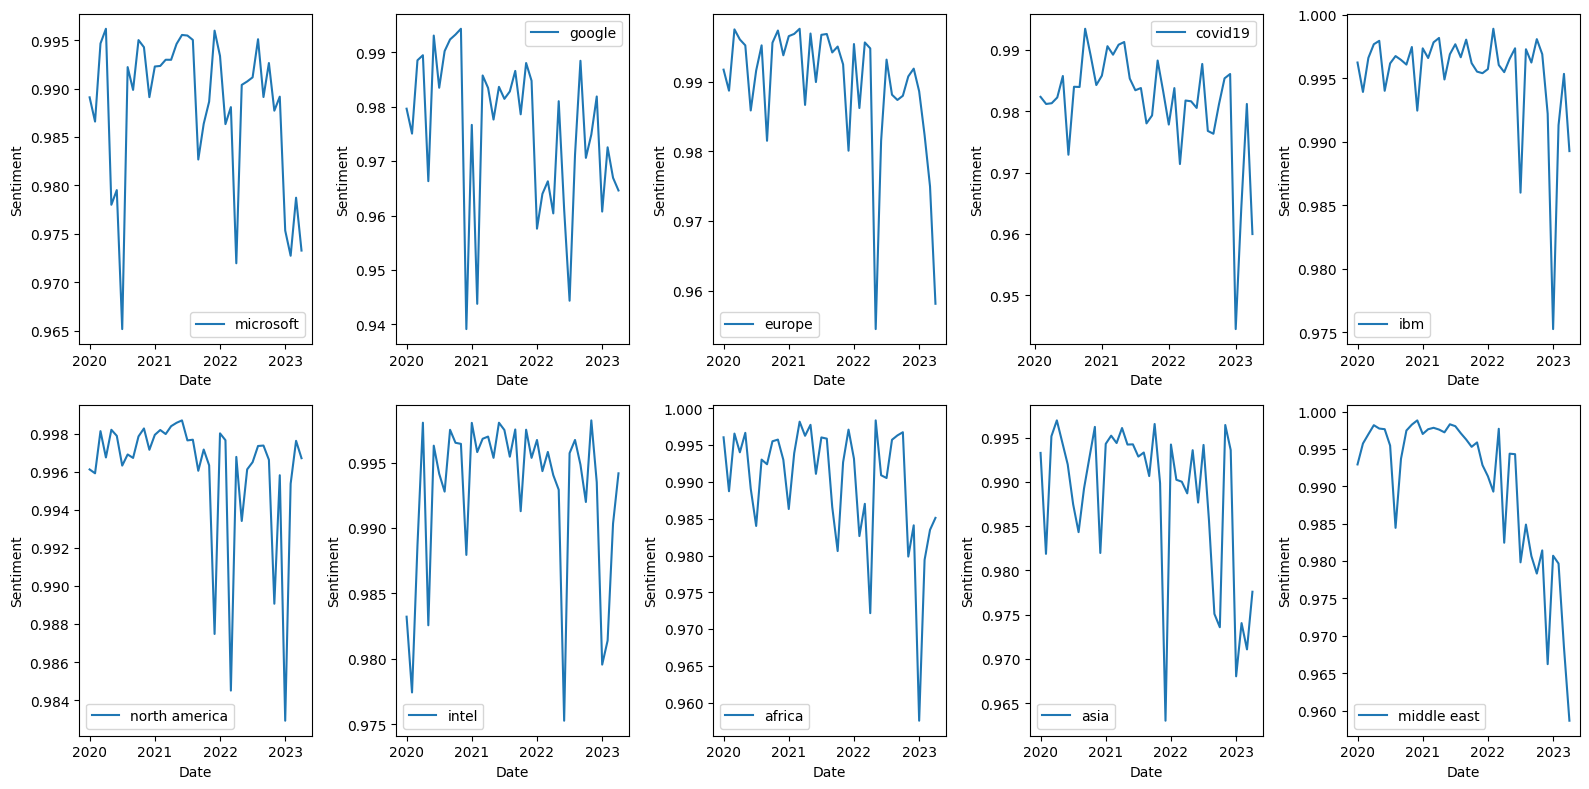

In [30]:
df_exploded_pos = df_pos.reset_index().explode('ent_text')



search_list_pos = ['microsoft', 'google', 'europe', 'covid19', 'ibm', 'north america', 'intel', 'africa','asia','middle east']
df_filtered_pos = df_exploded_pos[df_exploded_pos['ent_text'].isin(search_list_pos)]
df_filtered_pos = df_filtered_pos.reset_index(drop=True)

# group by date and calculate mean sentiment
grouped_pos = df_filtered_pos.groupby(['year','month', 'ent_text'])['sentiment_score'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for i, elem in enumerate(search_list_pos):
    row = i//5
    col = i%5
    data = grouped_pos[grouped_pos['ent_text'] == elem]
    axes[row, col].plot(data['year'] + (data['month']-1)/12, data['sentiment_score'], label=elem)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    axes[row, col].legend()
plt.tight_layout()
plt.show()

**Negative**

In [31]:
entities = [entity for entities in df_neg["ent_text"] for entity in entities]
top_entities_neg = [entity for entity, count in Counter(entities).most_common(10)]

rows_with_top_entities_neg = df_neg[df_neg["ent_text"].parallel_apply(lambda x: any(entity in top_entities_neg for entity in x))]
df_top_entities_neg = pd.DataFrame(rows_with_top_entities_neg)

grouped_neg = df_top_entities_neg.explode("ent_text").groupby(["date", "ent_text"])["sentiment_score"].mean().reset_index()

Counter(grouped_neg['ent_text']).most_common(10)

[('covid19', 762),
 ('google', 581),
 ('europe', 329),
 ('microsoft', 328),
 ('fcc', 286),
 ('congress', 245),
 ('donald trump', 221),
 ('cnn', 207),
 ('joe biden', 200),
 ('white house', 193)]

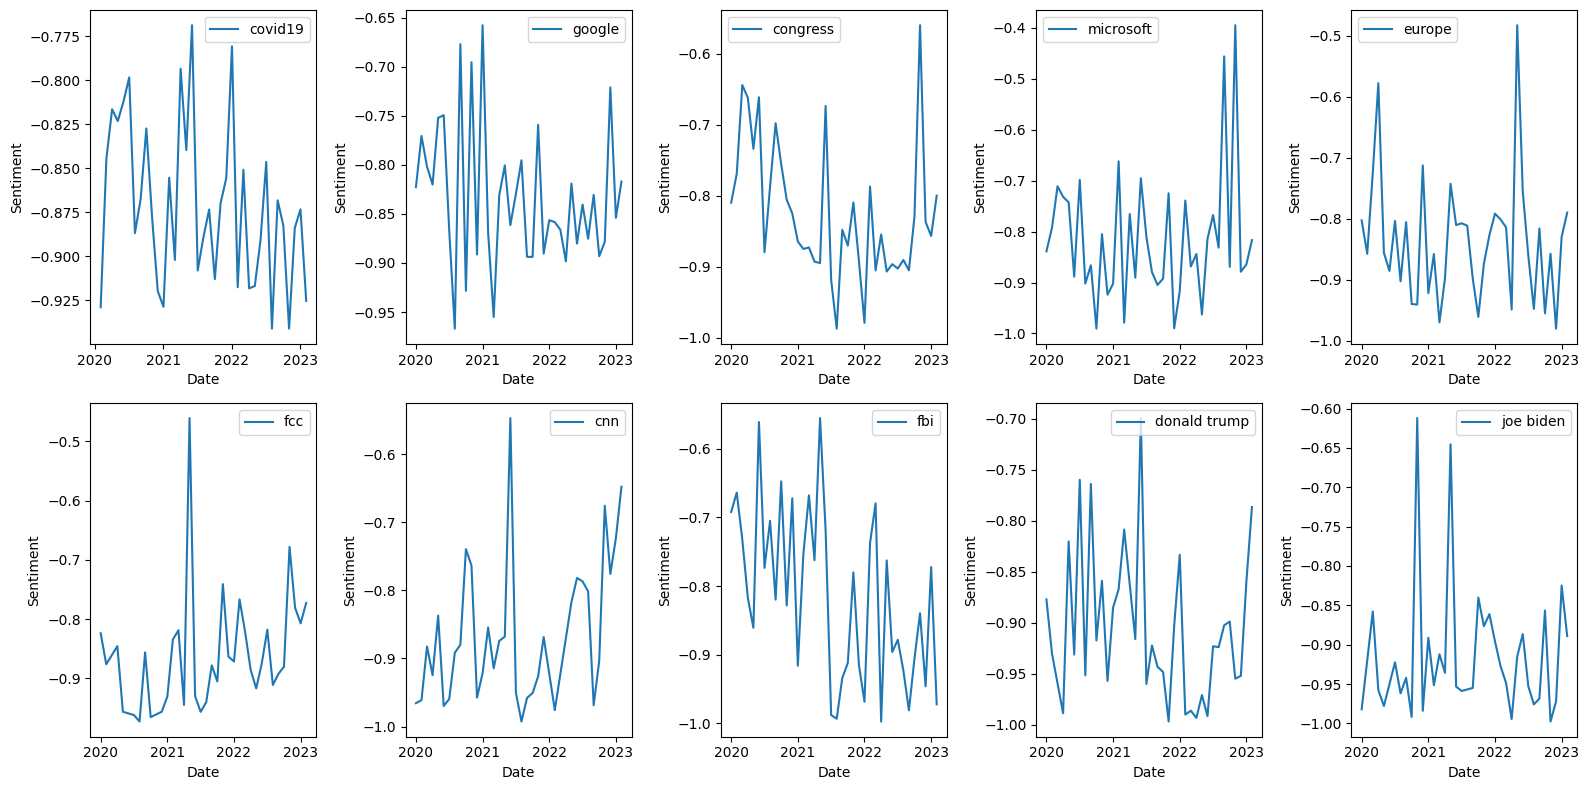

In [70]:
df_exploded_neg = df_neg.reset_index().explode('ent_text')



search_list_neg = ['covid19', 'google', 'congress', 'microsoft', 'europe', 'fcc', 'cnn', 'fbi','donald trump','joe biden']
# filter for rows with elements of interest
df_filtered_neg = df_exploded_neg[df_exploded_neg['ent_text'].isin(search_list_neg)]
df_filtered_neg = df_filtered_neg.reset_index(drop=True)

# group by date and element of interest, and calculate mean sentiment
grouped_neg = df_filtered_neg.groupby(['year','month', 'ent_text'])['sentiment_score'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

for i, elem in enumerate(search_list_neg):
    row = i//5
    col = i%5
    data = grouped_neg[grouped_neg['ent_text'] == elem]
    axes[row, col].plot(data['year'] + (data['month']-1)/12, data['sentiment_score'], label=elem)
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    axes[row, col].legend()

plt.tight_layout()
plt.show()